In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-05-18 15:46:45.999250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 15:46:46.120391: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 15:46:46.542422: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-05-18 15:46:46.542497: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 50

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12157
12157
12157
12157
12157
12157
12157
12157


In [7]:
######################
# ONLY HITS_top DATA #
######################

# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
num_data = 10000



hits_top_B = np.array( f_B['HITS_top_img/ev_1'] )
hits_top_S = np.array( f_S['HITS_top_img/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top_img/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top_img/ev_'+str(i)] )])
    
    

# close the h5 files
f_B.close()
f_S.close()



# X and Y for the classifier
X_mon = np.row_stack([hits_top_B,hits_top_S])
# normalize
#X_mon = scaler.fit_transform(X_mon)
X_mon = np.reshape(X_mon, (2*num_data,128,128,1))

del hits_top_B
del hits_top_S

# labels
y_mon = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (9999, 128, 128, 1)
y_mon_train :  (9999,)
X_mon_val :  (3334, 128, 128, 1)
y_mon_val :  (3334,)
X_mon_test :  (6667, 128, 128, 1)
y_mon_test :  (6667,)



### CLASSIFIER

In [8]:
from keras import backend as K
np.random.seed(0)

# Define recall, precision and f1 functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 1 conv layer

In [25]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (X_mon_train.shape[1], X_mon_train.shape[2], X_mon_train.shape[3])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

def run_CNN():
    model = CNN_model()
    model.fit(X_mon_train, y_mon_train, epochs=50, batch_size=100, verbose=1, validation_data=(X_mon_val, y_mon_val))
    model.save('model_save_name.h5')
    #model.save_weights('final_weights.h5')
    score = model.evaluate(X_mon_val, y_mon_val, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test f1:', score[2])
    print('Test precision:', score[3])
    print('Test recall:', score[4])

run_CNN()

Epoch 1/50
100/100 [==============================] - 17s 169ms/step - loss: 0.9945 - acc: 0.6436 - f1_m: 0.6393 - precision_m: 0.6464 - recall_m: 0.6661 - val_loss: 0.4634 - val_acc: 0.8494 - val_f1_m: 0.8457 - val_precision_m: 0.8558 - val_recall_m: 0.8394
Epoch 2/50
100/100 [==============================] - 25s 248ms/step - loss: 0.5298 - acc: 0.7949 - f1_m: 0.8005 - precision_m: 0.7778 - recall_m: 0.8331 - val_loss: 0.4480 - val_acc: 0.8467 - val_f1_m: 0.8409 - val_precision_m: 0.8644 - val_recall_m: 0.8220
Epoch 3/50
100/100 [==============================] - 31s 305ms/step - loss: 0.5059 - acc: 0.8025 - f1_m: 0.8085 - precision_m: 0.7879 - recall_m: 0.8394 - val_loss: 0.4620 - val_acc: 0.8494 - val_f1_m: 0.8535 - val_precision_m: 0.8207 - val_recall_m: 0.8935
Epoch 4/50
100/100 [==============================] - 32s 320ms/step - loss: 0.4844 - acc: 0.8143 - f1_m: 0.8214 - precision_m: 0.7957 - recall_m: 0.8556 - val_loss: 0.4267 - val_acc: 0.8452 - val_f1_m: 0.8402 - val_precisi

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 126, 126, 16)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 125, 125, 16)      0         
                                                                 
 flatten_4 (Flatten)         (None, 250000)            0         
                                                                 
 dense_8 (Dense)             (None, 32)                8000032   
                                                      

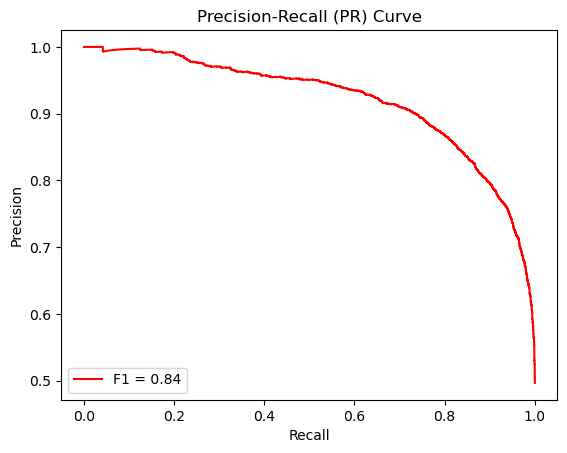

Accuracy: 0.8425078746062696
Average precision: 0.7823475654187502
recall: 0.8610271903323263
AUC:0.8792560562989205
Predicted   0.0   1.0
Actual               
0.0        2767   590
1.0         460  2850


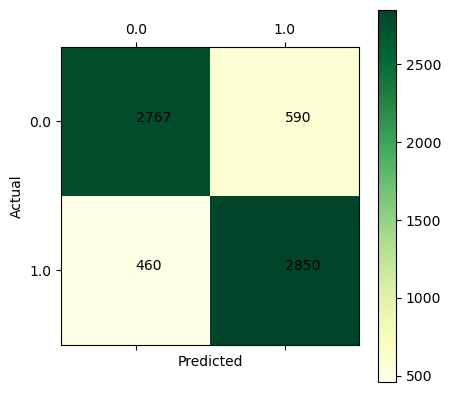

In [26]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model('model_save_name.h5', custom_objects=dependencies)

model.summary()



score = model.evaluate(X_mon_test, y_mon_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict(X_mon_test)    # Predict probabilities
yhat = model.predict(X_mon_test)      # Predict class values
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_mon_test, lr_probs)
lr_f1, lr_auc = f1_score(y_mon_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_mon_test[y_mon_test==1]) / len(y_mon_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_mon_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_mon_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_mon_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_mon_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_mon_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

209/209 [==============================] - 3s 13ms/step


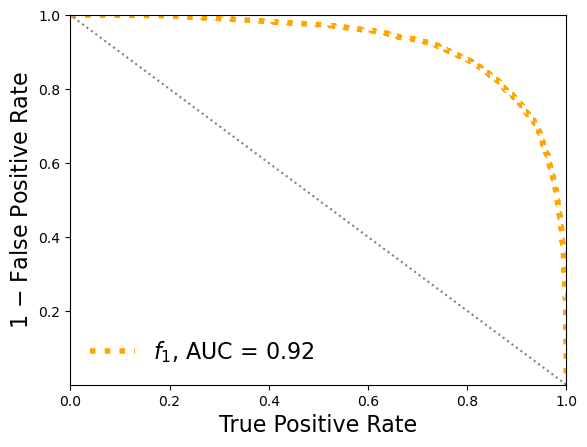

In [27]:

from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score

#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'CNN-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_CNN = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_CNN = dict()
tpr_CNN = dict()
roc_auc_CNN = dict()
fpr_CNN, tpr_CNN, _ = roc_curve(y_mon_test, y_pred_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)


plt.figure()
plt.plot(tpr_CNN,1-fpr_CNN,label="$f_{1}$, AUC = %0.2f" % roc_auc_CNN,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [28]:
roc_auc_CNN

0.9232119024413072

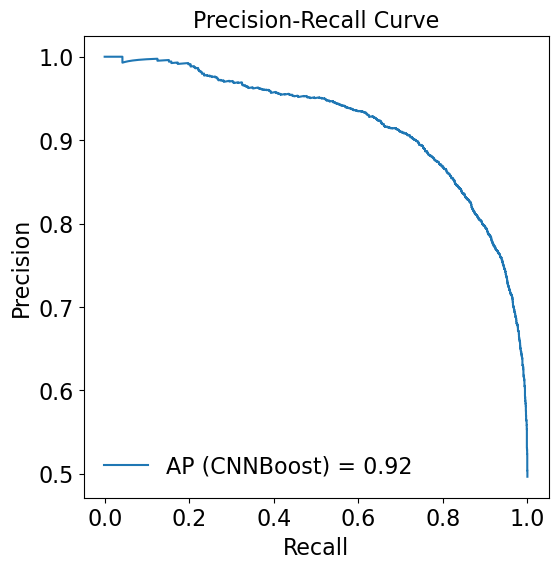

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_CNN, recall_CNN, _ = precision_recall_curve(y_mon_test, y_pred_CNN)
auc_CNN = auc(recall_CNN, precision_CNN)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_CNN, precision_CNN, label=f'AP (CNNBoost) = {auc_CNN:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [30]:
auc_CNN

0.9197728773720322

209/209 [==============================] - 3s 15ms/step
Classification score:


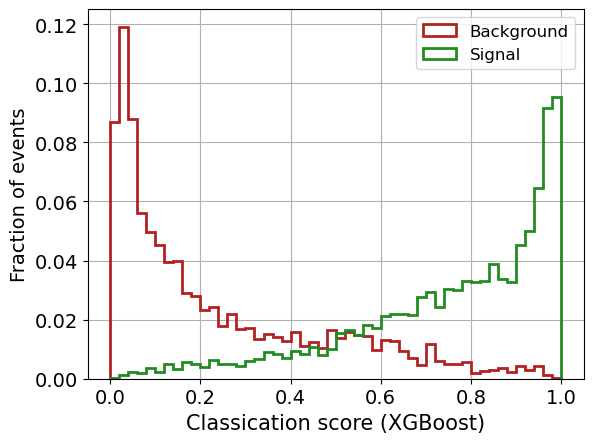

In [31]:
yhat = model.predict(X_mon_test) 

# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_CNN[i,0])
    else:
        pred_XG_NP.append(y_pred_CNN[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 2 conv layer

In [32]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (X_mon_train.shape[1], X_mon_train.shape[2], X_mon_train.shape[3])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    #model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    #model.add(keras.layers.LeakyReLU(alpha=0.05))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

def run_CNN():
    model = CNN_model()
    model.fit(X_mon_train, y_mon_train, epochs=50, batch_size=100, verbose=1, validation_data=(X_mon_val, y_mon_val))
    model.save('model_save_name.h5')
    #model.save_weights('final_weights.h5')
    score = model.evaluate(X_mon_val, y_mon_val, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test f1:', score[2])
    print('Test precision:', score[3])
    print('Test recall:', score[4])

run_CNN()

Epoch 1/50
100/100 [==============================] - 22s 208ms/step - loss: 1.0585 - acc: 0.5185 - f1_m: 0.5259 - precision_m: 0.5225 - recall_m: 0.5674 - val_loss: 0.8019 - val_acc: 0.4976 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 27s 267ms/step - loss: 0.7029 - acc: 0.6779 - f1_m: 0.6808 - precision_m: 0.7091 - recall_m: 0.7146 - val_loss: 0.5474 - val_acc: 0.8413 - val_f1_m: 0.8322 - val_precision_m: 0.8727 - val_recall_m: 0.7982
Epoch 3/50
100/100 [==============================] - 27s 271ms/step - loss: 0.5616 - acc: 0.8066 - f1_m: 0.7975 - precision_m: 0.8333 - recall_m: 0.7756 - val_loss: 0.4691 - val_acc: 0.8509 - val_f1_m: 0.8526 - val_precision_m: 0.8310 - val_recall_m: 0.8792
Epoch 4/50
100/100 [==============================] - 27s 270ms/step - loss: 0.5144 - acc: 0.8292 - f1_m: 0.8240 - precision_m: 0.8479 - recall_m: 0.8082 - val_loss: 0.4567 - val_acc: 0.8527 - val_f1_m: 0.8548 -

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 126, 126, 16)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 123, 123, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                  

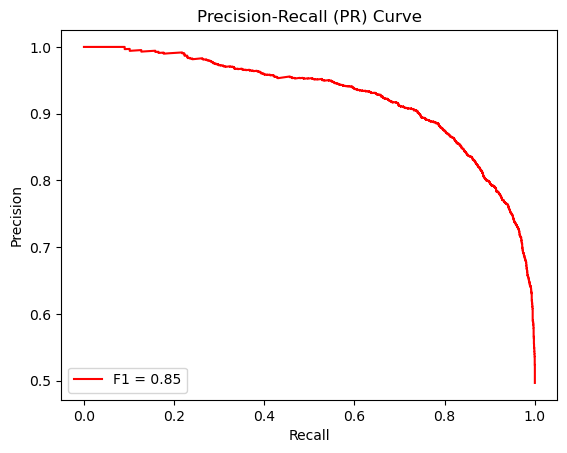

Accuracy: 0.8362081895905205
Average precision: 0.7665191753781295
recall: 0.9
AUC:0.8730857908976208
Predicted   0.0   1.0
Actual               
0.0        2596   761
1.0         331  2979


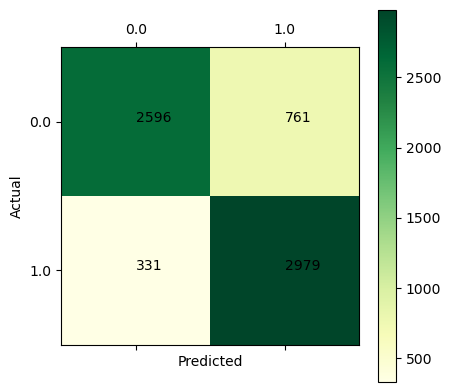

In [33]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model('model_save_name.h5', custom_objects=dependencies)

model.summary()



score = model.evaluate(X_mon_test, y_mon_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict(X_mon_test)    # Predict probabilities
yhat = model.predict(X_mon_test)      # Predict class values
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_mon_test, lr_probs)
lr_f1, lr_auc = f1_score(y_mon_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_mon_test[y_mon_test==1]) / len(y_mon_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_mon_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_mon_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_mon_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_mon_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_mon_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

209/209 [==============================] - 4s 20ms/step


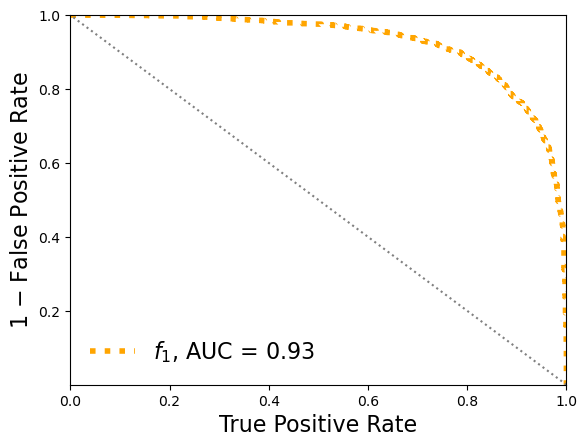

In [34]:

from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score

#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'CNN-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_CNN = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_CNN = dict()
tpr_CNN = dict()
roc_auc_CNN = dict()
fpr_CNN, tpr_CNN, _ = roc_curve(y_mon_test, y_pred_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)


plt.figure()
plt.plot(tpr_CNN,1-fpr_CNN,label="$f_{1}$, AUC = %0.2f" % roc_auc_CNN,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [35]:
roc_auc_CNN

0.9268011919000474

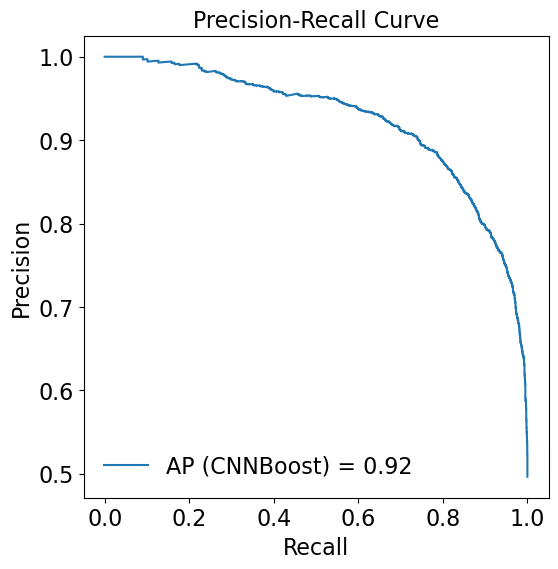

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_CNN, recall_CNN, _ = precision_recall_curve(y_mon_test, y_pred_CNN)
auc_CNN = auc(recall_CNN, precision_CNN)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_CNN, precision_CNN, label=f'AP (CNNBoost) = {auc_CNN:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [37]:
auc_CNN

0.9234207976938326

209/209 [==============================] - 4s 20ms/step
Classification score:


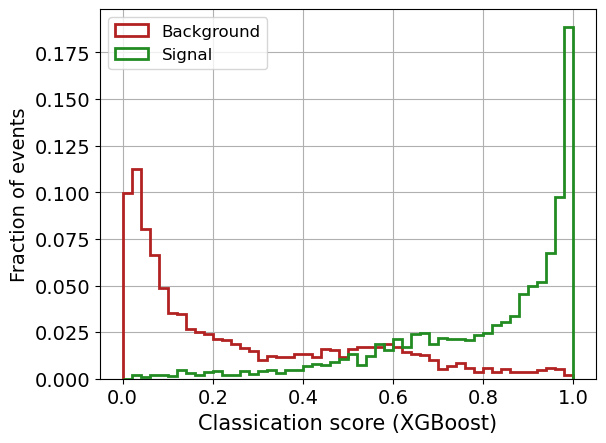

In [38]:
yhat = model.predict(X_mon_test) 

# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_CNN[i,0])
    else:
        pred_XG_NP.append(y_pred_CNN[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

#### 3 conv layer

In [18]:
# 1 conv layer / 100 bs / 50 epoch HitPeak images
def CNN_model():
    shape = (X_mon_train.shape[1], X_mon_train.shape[2], X_mon_train.shape[3])
    model = Sequential()
    
    # 1 conv layer
    model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=shape,kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (1,1)))

    # 2 conv layers
    model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3 conv layers
    model.add(Conv2D(16,(3,3),kernel_regularizer=l2(0.005)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) 
    model.add(Flatten())

    model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
    model.add(keras.layers.LeakyReLU(alpha=0.05))    
    model.add(Dropout(0.5)) 

    # Output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['acc', f1_m, precision_m, recall_m])
    return model

def run_CNN():
    model = CNN_model()
    model.fit(X_mon_train, y_mon_train, epochs=50, batch_size=100, verbose=1, validation_data=(X_mon_val, y_mon_val))
    model.save('model_save_name.h5')
    #model.save_weights('final_weights.h5')
    score = model.evaluate(X_mon_val, y_mon_val, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test f1:', score[2])
    print('Test precision:', score[3])
    print('Test recall:', score[4])

run_CNN()

Epoch 1/50
100/100 [==============================] - 26s 249ms/step - loss: 0.7381 - acc: 0.6623 - f1_m: 0.6295 - precision_m: 0.6920 - recall_m: 0.6561 - val_loss: 0.4987 - val_acc: 0.8443 - val_f1_m: 0.8354 - val_precision_m: 0.8770 - val_recall_m: 0.8004
Epoch 2/50
100/100 [==============================] - 20s 199ms/step - loss: 0.5100 - acc: 0.8231 - f1_m: 0.8201 - precision_m: 0.8358 - recall_m: 0.8142 - val_loss: 0.4559 - val_acc: 0.8482 - val_f1_m: 0.8431 - val_precision_m: 0.8627 - val_recall_m: 0.8271
Epoch 3/50
100/100 [==============================] - 22s 216ms/step - loss: 0.4831 - acc: 0.8315 - f1_m: 0.8287 - precision_m: 0.8398 - recall_m: 0.8245 - val_loss: 0.4657 - val_acc: 0.8365 - val_f1_m: 0.8483 - val_precision_m: 0.7846 - val_recall_m: 0.9284
Epoch 4/50
100/100 [==============================] - 26s 257ms/step - loss: 0.4747 - acc: 0.8338 - f1_m: 0.8335 - precision_m: 0.8373 - recall_m: 0.8360 - val_loss: 0.4374 - val_acc: 0.8491 - val_f1_m: 0.8529 - val_precisi

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 16)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 123, 123, 16)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                  

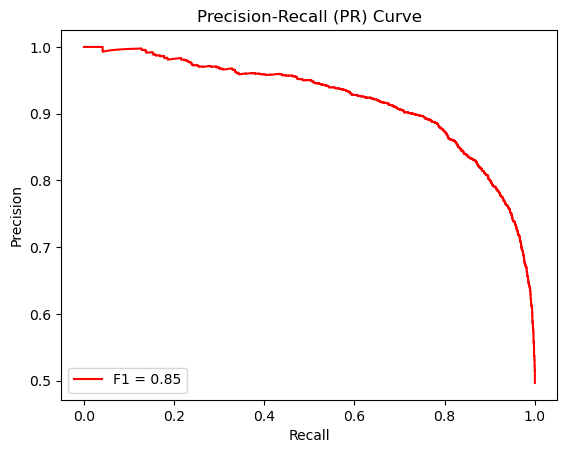

Accuracy: 0.8384580770961452
Average precision: 0.7690348002967754
recall: 0.9021148036253777
AUC:0.8746608137790256
Predicted   0.0   1.0
Actual               
0.0        2604   753
1.0         324  2986


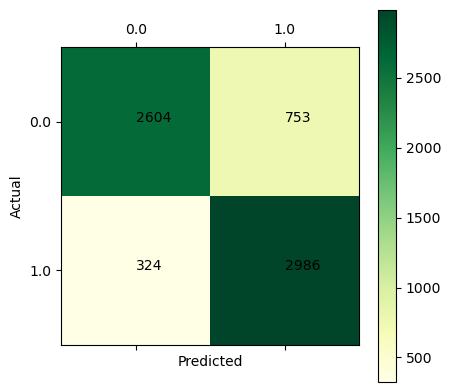

In [19]:
###########################
# TEST WITH THE TRAIN SET # just to see
###########################

dependencies = {
    'f1_m' : f1_m, 
    'precision_m' : precision_m,
    'recall_m': recall_m,
}

model = keras.models.load_model('model_save_name.h5', custom_objects=dependencies)

model.summary()



score = model.evaluate(X_mon_test, y_mon_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


lr_probs = model.predict(X_mon_test)    # Predict probabilities
yhat = model.predict(X_mon_test)      # Predict class values
yhat = np.round(yhat)
lr_precision, lr_recall, _ = precision_recall_curve(y_mon_test, lr_probs)
lr_f1, lr_auc = f1_score(y_mon_test, yhat), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores
''' plot the precision-recall curves '''
no_skill = len(y_mon_test[y_mon_test==1]) / len(y_mon_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

## Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_mon_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_mon_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_mon_test, test_predictions)
auc = auc(recall, precision)
recall1 = recall_score(y_mon_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_mon_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)

209/209 [==============================] - 6s 28ms/step


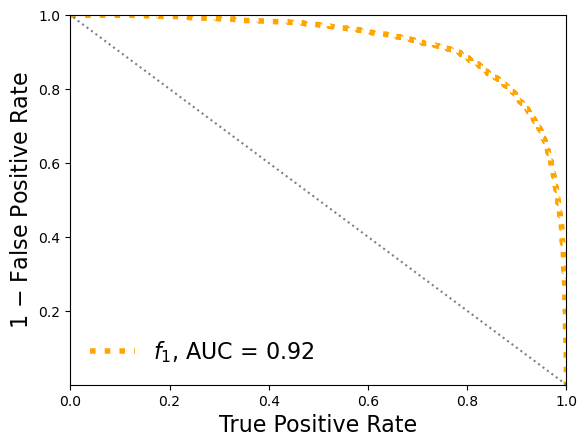

In [20]:

from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score

#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'CNN-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_CNN = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_CNN = dict()
tpr_CNN = dict()
roc_auc_CNN = dict()
fpr_CNN, tpr_CNN, _ = roc_curve(y_mon_test, y_pred_CNN)
roc_auc_CNN = auc(fpr_CNN, tpr_CNN)


plt.figure()
plt.plot(tpr_CNN,1-fpr_CNN,label="$f_{1}$, AUC = %0.2f" % roc_auc_CNN,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [22]:
roc_auc_CNN

0.9244224315516929

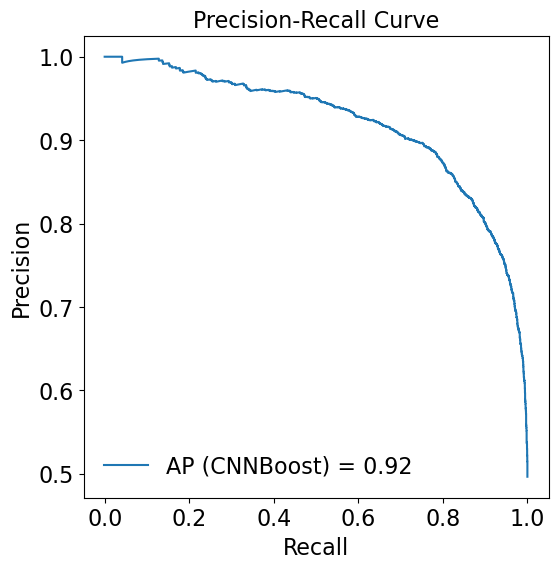

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_CNN, recall_CNN, _ = precision_recall_curve(y_mon_test, y_pred_CNN)
auc_CNN = auc(recall_CNN, precision_CNN)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_CNN, precision_CNN, label=f'AP (CNNBoost) = {auc_CNN:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [24]:
auc_CNN

0.9196804283768724

209/209 [==============================] - 6s 30ms/step
Classification score:


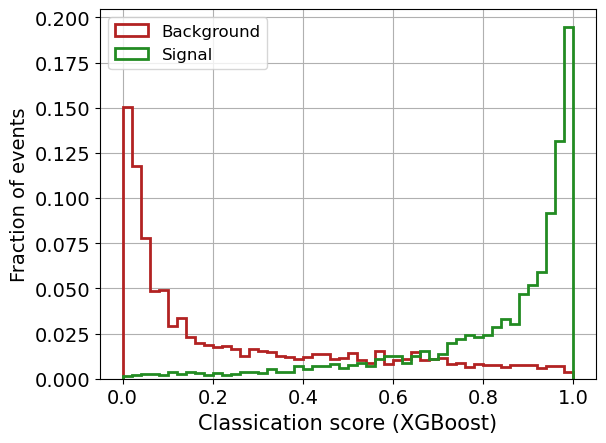

In [21]:
yhat = model.predict(X_mon_test) 

# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_CNN[i,0])
    else:
        pred_XG_NP.append(y_pred_CNN[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()